In [1]:
import json
import os

import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
from sklearn import metrics
import torch

from models import avg_speed, schedule, ff, persistent, rnn, transformer, conv
from utils import data_utils, data_loader, model_utils, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

%matplotlib inline

RUN_FOLDER = "../results/small/"
NETWORK = "kcm/"
FOLD_MODEL = 4
device = torch.device("cpu")
NUM_WORKERS = 4
HIDDEN_SIZE = 32
BATCH_SIZE = 64

# Set hyperparameters
EPOCH_EVAL_FREQ = 2

# Define embedded variables for network models
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}

# Get list of available train/test files
kcm_data_folder = f"{run_folder}kcm/deeptte_formatted/"
atb_data_folder = f"{run_folder}atb/deeptte_formatted/"

train_file_list_kcm = list(filter(lambda x: x[:5]=="train" and len(x)==6, os.listdir(kcm_data_folder)))
test_file_list_kcm = list(filter(lambda x: x[:4]=="test" and len(x)==5, os.listdir(kcm_data_folder)))
train_file_list_atb = list(filter(lambda x: x[:5]=="train" and len(x)==6, os.listdir(atb_data_folder)))
test_file_list_atb = list(filter(lambda x: x[:4]=="test" and len(x)==5, os.listdir(atb_data_folder)))

In [2]:
# Load KCM Models

In [3]:
# Declare baseline models
avg_model = data_utils.load_pkl(f"{run_folder}kcm/models/AVG_{FOLD_MODEL}.pkl")
sch_model = data_utils.load_pkl(f"{run_folder}kcm/models/SCH_{FOLD_MODEL}.pkl")
tim_model = data_utils.load_pkl(f"{run_folder}kcm/models/PER_TIM_{FOLD_MODEL}.pkl")

# Declare network models
ff_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
ff_model.load_state_dict(torch.load(f"{run_folder}kcm/models/{ff_model.model_name}_{FOLD_MODEL}.pt"))
print(ff_model.model_name)
print(sum(p.numel() for p in ff_model.parameters() if p.requires_grad))
gru_model = rnn.GRU_RNN(
    "GRU_RNN",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
gru_model.load_state_dict(torch.load(f"{run_folder}kcm/models/{gru_model.model_name}_{FOLD_MODEL}.pt"))
print(gru_model.model_name)
print(sum(p.numel() for p in gru_model.parameters() if p.requires_grad))
gru_mto_model = rnn.GRU_RNN_MTO(
    "GRU_RNN_MTO",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
gru_mto_model.load_state_dict(torch.load(f"{run_folder}kcm/models/{gru_mto_model.model_name}_{FOLD_MODEL}.pt"))
print(gru_mto_model.model_name)
print(sum(p.numel() for p in gru_mto_model.parameters() if p.requires_grad))
conv1d_model = conv.CONV(
    "CONV1D",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
conv1d_model.load_state_dict(torch.load(f"{run_folder}kcm/models/{conv1d_model.model_name}_{FOLD_MODEL}.pt"))
print(conv1d_model.model_name)
print(sum(p.numel() for p in conv1d_model.parameters() if p.requires_grad))
trs_model = transformer.TRANSFORMER(
    "TRSF_ENC",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
trs_model.load_state_dict(torch.load(f"{run_folder}kcm/models/{trs_model.model_name}_{FOLD_MODEL}.pt"))
print(trs_model.model_name)
print(sum(p.numel() for p in trs_model.parameters() if p.requires_grad))

# Add all models to results list
model_list = []
model_list.append(avg_model)
model_list.append(sch_model)
model_list.append(tim_model)
model_list.append(ff_model)
model_list.append(gru_model)
model_list.append(gru_mto_model)
model_list.append(conv1d_model)
model_list.append(trs_model)

FF
36957
GRU_RNN
38681
GRU_RNN_MTO
38681
CONV1D
35449
TRSF_ENC
50313


In [4]:
model_fold_results = {}
for x in model_list:
    model_fold_results[x.model_name] = {"Labels":[], "Preds":[]}
for valid_file in test_file_list_kcm:
    print(f"VALIDATE ON FILE: {valid_file}")

    # These are fold holdouts, separate validation files are used for generalization
    valid_data = data_utils.load_all_data(kcm_data_folder, valid_file)
    with open(f"{kcm_data_folder}{valid_file}_config.json", "r") as f:
        config = json.load(f)

    # Construct dataloaders for network models
    valid_dataloader_basic = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.basic_collate, NUM_WORKERS)
    valid_dataloader_seq = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.sequential_collate, NUM_WORKERS)
    valid_dataloader_seq_mto = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.sequential_mto_collate, NUM_WORKERS)
    valid_dataloader_trs = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.transformer_collate, NUM_WORKERS)
    print(f"Successfully loaded {len(valid_data)} testing samples.")

    print(f"Evaluating {avg_model.model_name}")
    avg_labels, avg_preds = avg_model.predict(valid_dataloader_basic, config)
    model_fold_results[avg_model.model_name]["Labels"].extend(list(avg_labels))
    model_fold_results[avg_model.model_name]["Preds"].extend(list(avg_preds))

    print(f"Evaluating {sch_model.model_name}")
    sch_labels, sch_preds = sch_model.predict(valid_dataloader_basic, config)
    model_fold_results[sch_model.model_name]["Labels"].extend(list(sch_labels))
    model_fold_results[sch_model.model_name]["Preds"].extend(list(sch_preds))

    print(f"Evaluating {tim_model.model_name}")
    tim_labels, tim_preds = tim_model.predict(valid_dataloader_seq, config)
    model_fold_results[tim_model.model_name]["Labels"].extend(list(tim_labels))
    model_fold_results[tim_model.model_name]["Preds"].extend(list(tim_preds))

    print(f"Evaluating {ff_model.model_name}")
    ff_labels, ff_preds = ff_model.evaluate(valid_dataloader_basic, config)
    model_fold_results[ff_model.model_name]["Labels"].extend(list(ff_labels))
    model_fold_results[ff_model.model_name]["Preds"].extend(list(ff_preds))

    print(f"Evaluating {gru_model.model_name}")
    gru_labels, gru_preds = gru_model.evaluate(valid_dataloader_seq, config)
    model_fold_results[gru_model.model_name]["Labels"].extend(list(gru_labels))
    model_fold_results[gru_model.model_name]["Preds"].extend(list(gru_preds))

    print(f"Evaluating {gru_mto_model.model_name}")
    gru_mto_labels, gru_mto_preds = gru_mto_model.evaluate(valid_dataloader_seq_mto, config)
    model_fold_results[gru_mto_model.model_name]["Labels"].extend(list(gru_mto_labels))
    model_fold_results[gru_mto_model.model_name]["Preds"].extend(list(gru_mto_preds))

    print(f"Evaluating {conv1d_model.model_name}")
    conv1d_labels, conv1d_preds = conv1d_model.evaluate(valid_dataloader_seq, config)
    model_fold_results[conv1d_model.model_name]["Labels"].extend(list(conv1d_labels))
    model_fold_results[conv1d_model.model_name]["Preds"].extend(list(conv1d_preds))

    print(f"Evaluating {trs_model.model_name}")
    trs_labels, trs_preds = trs_model.evaluate(valid_dataloader_trs, config)
    model_fold_results[trs_model.model_name]["Labels"].extend(list(trs_labels))
    model_fold_results[trs_model.model_name]["Preds"].extend(list(trs_preds))
kcm_kcm_model_fold_results = model_fold_results


model_fold_results = {}
for x in model_list:
    model_fold_results[x.model_name] = {"Labels":[], "Preds":[]}
for valid_file in test_file_list_atb:
    print(f"VALIDATE ON FILE: {valid_file}")

    # These are fold holdouts, separate validation files are used for generalization
    valid_data = data_utils.load_all_data(kcm_data_folder, valid_file)
    with open(f"{kcm_data_folder}{valid_file}_config.json", "r") as f:
        config = json.load(f)

    # Construct dataloaders for network models
    valid_dataloader_basic = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.basic_collate, NUM_WORKERS)
    valid_dataloader_seq = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.sequential_collate, NUM_WORKERS)
    valid_dataloader_seq_mto = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.sequential_mto_collate, NUM_WORKERS)
    valid_dataloader_trs = data_loader.make_generic_dataloader(valid_data, config, BATCH_SIZE, data_loader.transformer_collate, NUM_WORKERS)
    print(f"Successfully loaded {len(valid_data)} testing samples.")

    print(f"Evaluating {avg_model.model_name}")
    avg_labels, avg_preds = avg_model.predict(valid_dataloader_basic, config)
    model_fold_results[avg_model.model_name]["Labels"].extend(list(avg_labels))
    model_fold_results[avg_model.model_name]["Preds"].extend(list(avg_preds))

    print(f"Evaluating {sch_model.model_name}")
    sch_labels, sch_preds = sch_model.predict(valid_dataloader_basic, config)
    model_fold_results[sch_model.model_name]["Labels"].extend(list(sch_labels))
    model_fold_results[sch_model.model_name]["Preds"].extend(list(sch_preds))

    print(f"Evaluating {tim_model.model_name}")
    tim_labels, tim_preds = tim_model.predict(valid_dataloader_seq, config)
    model_fold_results[tim_model.model_name]["Labels"].extend(list(tim_labels))
    model_fold_results[tim_model.model_name]["Preds"].extend(list(tim_preds))

    print(f"Evaluating {ff_model.model_name}")
    ff_labels, ff_preds = ff_model.evaluate(valid_dataloader_basic, config)
    model_fold_results[ff_model.model_name]["Labels"].extend(list(ff_labels))
    model_fold_results[ff_model.model_name]["Preds"].extend(list(ff_preds))

    print(f"Evaluating {gru_model.model_name}")
    gru_labels, gru_preds = gru_model.evaluate(valid_dataloader_seq, config)
    model_fold_results[gru_model.model_name]["Labels"].extend(list(gru_labels))
    model_fold_results[gru_model.model_name]["Preds"].extend(list(gru_preds))

    print(f"Evaluating {gru_mto_model.model_name}")
    gru_mto_labels, gru_mto_preds = gru_mto_model.evaluate(valid_dataloader_seq_mto, config)
    model_fold_results[gru_mto_model.model_name]["Labels"].extend(list(gru_mto_labels))
    model_fold_results[gru_mto_model.model_name]["Preds"].extend(list(gru_mto_preds))

    print(f"Evaluating {conv1d_model.model_name}")
    conv1d_labels, conv1d_preds = conv1d_model.evaluate(valid_dataloader_seq, config)
    model_fold_results[conv1d_model.model_name]["Labels"].extend(list(conv1d_labels))
    model_fold_results[conv1d_model.model_name]["Preds"].extend(list(conv1d_preds))

    print(f"Evaluating {trs_model.model_name}")
    trs_labels, trs_preds = trs_model.evaluate(valid_dataloader_trs, config)
    model_fold_results[trs_model.model_name]["Labels"].extend(list(trs_labels))
    model_fold_results[trs_model.model_name]["Preds"].extend(list(trs_preds))
kcm_atb_model_fold_results = model_fold_results


VALIDATE ON FILE: test0
Successfully loaded 55215 testing samples.
Evaluating AVG
Evaluating SCH
Evaluating PER_TIM
Evaluating FF
Evaluating GRU_RNN
Evaluating GRU_RNN_MTO
Evaluating CONV1D
Evaluating TRSF_ENC
VALIDATE ON FILE: test0
Successfully loaded 55215 testing samples.
Evaluating AVG
Evaluating SCH
Evaluating PER_TIM
Evaluating FF
Evaluating GRU_RNN
Evaluating GRU_RNN_MTO
Evaluating CONV1D
Evaluating TRSF_ENC


In [5]:
# Load ATB Models

In [6]:
# Declare baseline models
avg_model = data_utils.load_pkl(f"{run_folder}atb/models/AVG_{FOLD_MODEL}.pkl")
sch_model = data_utils.load_pkl(f"{run_folder}atb/models/SCH_{FOLD_MODEL}.pkl")
tim_model = data_utils.load_pkl(f"{run_folder}atb/models/PER_TIM_{FOLD_MODEL}.pkl")

# Declare network models
ff_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
ff_model.load_state_dict(torch.load(f"{run_folder}atb/models/{ff_model.model_name}_{FOLD_MODEL}.pt"))
print(ff_model.model_name)
print(sum(p.numel() for p in ff_model.parameters() if p.requires_grad))
gru_model = rnn.GRU_RNN(
    "GRU_RNN",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
gru_model.load_state_dict(torch.load(f"{run_folder}atb/models/{gru_model.model_name}_{FOLD_MODEL}.pt"))
print(gru_model.model_name)
print(sum(p.numel() for p in gru_model.parameters() if p.requires_grad))
gru_mto_model = rnn.GRU_RNN_MTO(
    "GRU_RNN_MTO",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
gru_mto_model.load_state_dict(torch.load(f"{run_folder}atb/models/{gru_mto_model.model_name}_{FOLD_MODEL}.pt"))
print(gru_mto_model.model_name)
print(sum(p.numel() for p in gru_mto_model.parameters() if p.requires_grad))
conv1d_model = conv.CONV(
    "CONV1D",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
conv1d_model.load_state_dict(torch.load(f"{run_folder}atb/models/{conv1d_model.model_name}_{FOLD_MODEL}.pt"))
print(conv1d_model.model_name)
print(sum(p.numel() for p in conv1d_model.parameters() if p.requires_grad))
trs_model = transformer.TRANSFORMER(
    "TRSF_ENC",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict,
    device
).to(device)
trs_model.load_state_dict(torch.load(f"{run_folder}atb/models/{trs_model.model_name}_{FOLD_MODEL}.pt"))
print(trs_model.model_name)
print(sum(p.numel() for p in trs_model.parameters() if p.requires_grad))

# Add all models to results list
model_list = []
model_list.append(avg_model)
model_list.append(sch_model)
model_list.append(tim_model)
model_list.append(ff_model)
model_list.append(gru_model)
model_list.append(gru_mto_model)
model_list.append(conv1d_model)
model_list.append(trs_model)

FF
36957
GRU_RNN
38681
GRU_RNN_MTO
38681
CONV1D
35449
TRSF_ENC
50313


In [7]:
# Test ATB on ATB
train_network = "ATB"
test_network = "ATB"
labels, preds = atb_model_baseline.predict(atb_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, atb_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(atb_dataloader_seq)
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, atb_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, atb_mask_seq)
# labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

VALIDATE ON FILE: test0
Successfully loaded 55215 testing samples.
Evaluating AVG
Evaluating SCH
Evaluating PER_TIM
Evaluating FF
Evaluating GRU_RNN
Evaluating GRU_RNN_MTO
Evaluating CONV1D
Evaluating TRSF_ENC
VALIDATE ON FILE: test0
Successfully loaded 55215 testing samples.
Evaluating AVG
Evaluating SCH
Evaluating PER_TIM
Evaluating FF
Evaluating GRU_RNN
Evaluating GRU_RNN_MTO
Evaluating CONV1D
Evaluating TRSF_ENC


In [8]:
# Test ATB on KCM
train_network = "ATB"
test_network = "KCM"
labels, preds = atb_model_baseline.predict(kcm_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, kcm_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(kcm_dataloader_seq)
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, kcm_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
# labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

In [18]:
# Gather generalization results, calculate metrics
gen_df = pd.concat(all_results)
gen_df['Residuals'] = abs(gen_df['Labels'] - gen_df['Preds'])

metric_results = gen_df.groupby(['Model','Train Network','Test Network'], as_index=False).apply(lambda x: np.round(np.sqrt(metrics.mean_squared_error(x.Labels, x.Preds)), 2))
metric_results.columns = ["Model","Train Network","Test Network","Metric"]
metric_results['Model-Train-Test'] = metric_results['Model']+"_"+metric_results['Train Network']+"_"+metric_results['Test Network']
metric_results = metric_results.sort_values('Model-Train-Test')

In [19]:
models = []
train_nets = []
test_nets = []
errors = []
results = kcm_kcm_model_fold_results
for model_name in results.keys():
    models.append(model_name)
    train_nets.append("KCM")
    test_nets.append("KCM")
    errors.append(np.round(np.sqrt(metrics.mean_squared_error(results[model_name]['Labels'], results[model_name]['Preds'])), 2))
results = kcm_atb_model_fold_results
for model_name in results.keys():
    models.append(model_name)
    train_nets.append("KCM")
    test_nets.append("ATB")
    errors.append(np.round(np.sqrt(metrics.mean_squared_error(results[model_name]['Labels'], results[model_name]['Preds'])), 2))
results = atb_atb_model_fold_results
for model_name in results.keys():
    models.append(model_name)
    train_nets.append("ATB")
    test_nets.append("ATB")
    errors.append(np.round(np.sqrt(metrics.mean_squared_error(results[model_name]['Labels'], results[model_name]['Preds'])), 2))
results = atb_kcm_model_fold_results
for model_name in results.keys():
    models.append(model_name)
    train_nets.append("ATB")
    test_nets.append("KCM")
    errors.append(np.round(np.sqrt(metrics.mean_squared_error(results[model_name]['Labels'], results[model_name]['Preds'])), 2))

metric_results = pd.DataFrame(columns=["Model","Train Network","Test Network","Metric"])
metric_results['Model'] = models
metric_results['Train Network'] = train_nets
metric_results['Test Network'] = test_nets
metric_results['Metric'] = errors
metric_results['Model-Train-Test'] = metric_results['Model']+"_"+metric_results['Train Network']+"_"+metric_results['Test Network']
metric_results = metric_results.sort_values('Model-Train-Test')
metric_results

,Model,Train Network,Test Network,Metric,Model-Train-Test
16,AVG,ATB,ATB,634.810000,AVG_ATB_ATB
1,AVG,ATB,KCM,324.790000,AVG_ATB_KCM
2,AVG,KCM,ATB,514.220000,AVG_KCM_ATB
3,AVG,KCM,KCM,388.230000,AVG_KCM_KCM
0,DEEPTTE,ATB,ATB,106.859946,DEEPTTE_ATB_ATB
1,DEEPTTE,ATB,KCM,394.266132,DEEPTTE_ATB_KCM
0,DEEPTTE,KCM,ATB,170.857417,DEEPTTE_KCM_ATB
1,DEEPTTE,KCM,KCM,287.064604,DEEPTTE_KCM_KCM
4,FF,ATB,ATB,198.220000,FF_ATB_ATB
5,FF,ATB,KCM,237.600000,FF_ATB_KCM


In [ ]:
# Include DeepTTE Generalization Results
kcm_deeptte_gen_res = data_utils.extract_deeptte_results("KCM", run_folder, "kcm/", generalization_flag=True)
atb_deeptte_gen_res = data_utils.extract_deeptte_results("ATB", run_folder, "atb/", generalization_flag=True)
deeptte_gen_res = pd.concat([kcm_deeptte_gen_res, atb_deeptte_gen_res])
deeptte_gen_res["Model"] = "DEEPTTE"
deeptte_gen_res["Train Network"] = deeptte_gen_res["City"]
deeptte_gen_res["Test Network"] = deeptte_gen_res["Loss Set"]
deeptte_gen_res["Metric"] = deeptte_gen_res["RMSE"]
deeptte_gen_res = deeptte_gen_res[["Model","Train Network","Test Network","Metric"]]
deeptte_gen_res['Model-Train-Test'] = deeptte_gen_res['Model']+"_"+deeptte_gen_res['Train Network']+"_"+deeptte_gen_res['Test Network']
metric_results = pd.concat([metric_results, deeptte_gen_res])
metric_results = metric_results.sort_values('Model-Train-Test')
metric_results

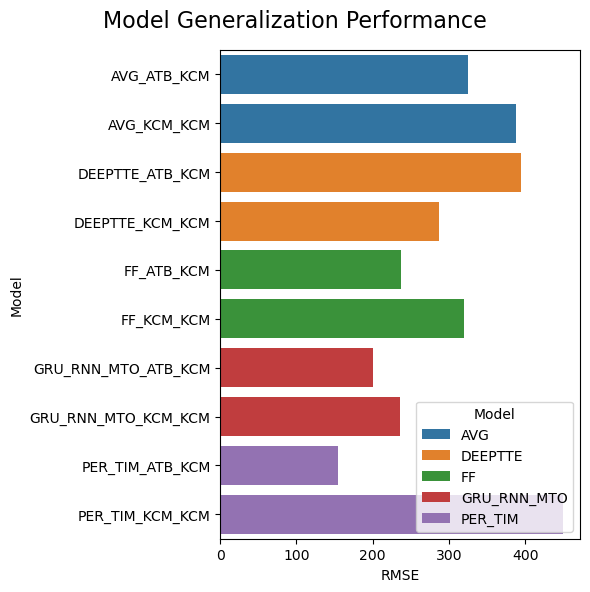

In [23]:
plot_data = metric_results[metric_results['Test Network']=="KCM"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="Metric", y="Model-Train-Test", hue="Model", dodge=False)
axes.set_ylabel("Model")
axes.set_xlabel("RMSE")
fig.suptitle('Model Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization.png", dpi=1800, bbox_inches='tight')

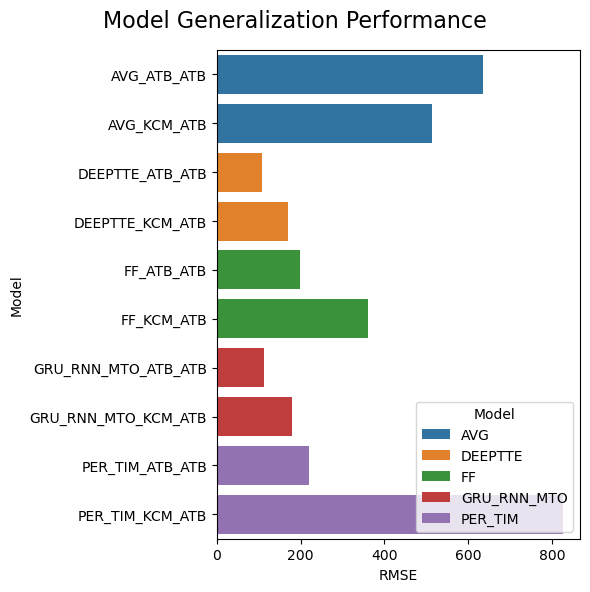

In [24]:
plot_data = metric_results[metric_results['Test Network']=="ATB"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="Metric", y="Model-Train-Test", hue="Model", dodge=False)
axes.set_ylabel("Model")
axes.set_xlabel("RMSE")
fig.suptitle('Model Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization.png", dpi=1800, bbox_inches='tight')